## Name: Shih-Hui Huang
## Github Username: Sylvie515
## USC ID: 6719561648

In [1]:
import pandas as pd

import cv2

import os
from pathlib import Path

import numpy as np
import random

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, vgg16
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, classification_report
import matplotlib.pyplot as plt

Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
def get_project_root():
    if "COLAB_GPU" in os.environ:
        return Path("/content/drive/MyDrive/final-project-Sylvie515")
    else:
        return Path(__file__).parent.parent

project_root = get_project_root()

### 1. Transfer Learning for Image Classification
### It is highly recommended that you complete this project using Keras and Python.
#### (a) In this problem, we are trying to build a classifier that distinguishes images of six scene.
#### (b) Data Exploration and Pre-processing
#### i. Images in each class are given in separate folders in the training and test sets. You can encode your classes using one-hot encoding.

In [4]:
Classes = pd.DataFrame([["buildings", 1], ["forest", 2], ["glacier", 3], ["mountain", 4], ["sea", 5], ["street", 6]],
                       columns = ["folder_name", "class"])
# one-hot encoding
one_hot_classes = pd.get_dummies(Classes["class"])
one_hot_classes.columns = Classes["folder_name"].values
one_hot_classes = one_hot_classes.astype(int)
one_hot_classes.insert(0, "folder_name", Classes["folder_name"])

one_hot_classes

,folder_name,buildings,forest,glacier,mountain,sea,street
0,buildings,1,0,0,0,0,0
1,forest,0,1,0,0,0,0
2,glacier,0,0,1,0,0,0
3,mountain,0,0,0,1,0,0
4,sea,0,0,0,0,1,0
5,street,0,0,0,0,0,1


#### ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [5]:
# resize images
def resize_image(image_path, output_path, target_size = (224, 224)):
    # load the image
    image = cv2.imread(image_path)
    # get original dimension
    h, w = image.shape[:2]
    # calculate aspect ratio
    aspect_ratio = w / h
    target_aspect_ratio = target_size[0] / target_size[1]
    if aspect_ratio > target_aspect_ratio:
        new_w = target_size[0]
        new_h = int(new_w / aspect_ratio)
    else:  # Taller than target or square
        new_h = target_size[1]
        new_w = int(new_h * aspect_ratio)

    # resize image & maintain aspect ratio
    resized_image = cv2.resize(image, (new_w, new_h))

    # create new black image with the target size
    new_image = np.zeros((target_size[1], target_size[0], 3), dtype = np.uint8)
    # place the resized image in the center of black image
    y_offset = (target_size[1] - new_h) // 2
    x_offset = (target_size[0] - new_w) // 2
    new_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image
    resized_image = new_image

    # save new image
    cv2.imwrite(output_path, resized_image)

In [ ]:
## path to read all images

# root directory
root_image_folder = project_root / "data/raw"

# get all folders' path in root_directory
folders_1 = [folder for folder in root_image_folder.iterdir() if folder.is_dir()]

for folder_1 in folders_1:
    # current folder name (seg_train, seg_test)
    folder_name_1 = folder_1.name
    # create new folder (output image folder)
    output_dir_1 = project_root / "data/processed" / folder_name_1
    os.makedirs(output_dir_1, exist_ok = True)

    # get all folders' path in folders_1
    folders_2 = [folder for folder in folder_1.iterdir() if folder.is_dir()]

    for folder_2 in folders_2:
        # current folder name (buildings, forest, glacier, mountain, sea, street)
        folder_name_2 = folder_2.name
        # create new folder (output image folder)
        output_dir_2 = output_dir_1 / folder_name_2
        os.makedirs(output_dir_2, exist_ok = True)

        ## get all images' path in folders_2
        # use iterdir() to iterate over images in this folder
        for image in folder_2.iterdir():
            # ensure we're only processing files, not folders
            if image.is_file():
                # current image name
                image_name = image.name
                # current image path
                image_path = str(image)
                # output image path
                output_path = str(output_dir_2 / image_name)

                # resize images
                resize_image(image_path, output_path)

#### (c) Transfer Learning
#### i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.
#### ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [6]:
# crop image (for example, left and upper half)
def crop_image(image_path, output_path):
    # load the image
    image = cv2.imread(image_path)
    # get original dimension
    h, w = image.shape[:2]
    # crop image
    cropped_image = image[0:h//2, 0:w//2]
    # save new image
    cv2.imwrite(output_path, cropped_image)

# randomly zoom image (for example, between 0.5 and 1.2)
def random_zoom_image(image_path, output_path, min_zoomfactor = 0.5, max_zoomfactor = 1.2):
    # load the image
    image = cv2.imread(image_path)
    # get original dimension
    h, w = image.shape[:2]
    # random zoom factor
    zoom_factor = random.uniform(min_zoomfactor, max_zoomfactor)
    new_h, new_w = int(h*zoom_factor), int(w*zoom_factor)
    # zoom image
    zoomed_image = cv2.resize(image, (new_w, new_h))
    # zoom in: crop
    if zoom_factor > 1:
        lower_y = (new_h - h) // 2
        left_x = (new_w - w) // 2
        zoomed_image = zoomed_image[lower_y:lower_y+h, left_x:left_x+w]
    # zoom out: pad with black
    else:
        # create a black image
        black_image = np.zeros((h, w, 3), dtype = np.uint8)
        lower_y = (h - new_h) // 2
        left_x = (w - new_w) // 2
        # copy image into center of black image
        black_image[lower_y:lower_y+new_h, left_x:left_x+new_w] = zoomed_image
        zoomed_image = black_image
    # save new image
    cv2.imwrite(output_path, zoomed_image)

# rotate image (for example, rotate 60 degrees)
def rotate_image(image_path, output_path):
    # load the image
    image = cv2.imread(image_path)
    # get original dimension
    h, w = image.shape[:2]
    # rotate image
    angle = 60
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (w, h))
    # save new image
    cv2.imwrite(output_path, rotated_image)

# flip image (for example, flip horizontally)
def flip_image(image_path, output_path):
    # load the image
    image = cv2.imread(image_path)
    # flip image (flip code = 0 to flip vertically, flip code = 1 to flip horizontally)
    flipped_image = cv2.flip(image, 1)
    # save new image
    cv2.imwrite(output_path, flipped_image)

# contrast image
def contrast_image(image_path, output_path):
    # load the image
    image = cv2.imread(image_path)
    # define alpha (contrast control) & beta (brightness control)
    alpha = 1.5
    beta = 0
    # contrast image
    contrasted_image = cv2.convertScaleAbs(image, alpha = alpha, beta = beta)
    # save new image
    cv2.imwrite(output_path, contrasted_image)

# translate image
def translate_image(image_path, output_path):
    # load the image
    image = cv2.imread(image_path)
    # get original dimension
    h, w = image.shape[:2]
    # translate image
    M = np.float32([[1, 0, 75], [0, 1, 75]])
    translated_image = cv2.warpAffine(image, M, (w, h))
    # save new image
    cv2.imwrite(output_path, translated_image)

In [ ]:
'''
## path to read all images in training set to perform empirical regularization for image augmentation

# root directory
root_image_folder = project_root / "data/processed/seg_train"

# get all folders' path in root_directory
folders = [folder for folder in root_image_folder.iterdir() if folder.is_dir()]

for folder in folders:
    # current folder name (buildings, forest, glacier, mountain, sea, street)
    folder_name = folder.name
    # create new folder for each augmentation type (output image folder)
    augmentation_types = ["crop", "zoom", "rotate", "flip", "contrast", "translate"]
    for augmentation_type in augmentation_types:
        output_dir = project_root / "data/processed/image_augmentation/train" / augmentation_type / folder_name
        os.makedirs(output_dir, exist_ok = True)

    ## get all images' path in folders
    # use iterdir() to iterate over images in this folder
    for image in folder.iterdir():
        # ensure we're only processing files, not folders
        if image.is_file():
            # current image name
            image_name = image.name
            # current image path
            image_path = str(image)

            # output image path
            output_path = str(project_root / "data/processed/image_augmentation/train/crop" / folder_name / image_name)
            # crop image (for example, left and upper half)
            crop_image(image_path, output_path)

            # output image path
            output_path = str(project_root / "data/processed/image_augmentation/train/zoom" / folder_name / image_name)
            # randomly zoom image (for example, between 0.5 and 1.2)
            random_zoom_image(image_path, output_path, min_zoomfactor = 0.5, max_zoomfactor = 1.2)

            # output image path
            output_path = str(project_root / "data/processed/image_augmentation/train/rotate" / folder_name / image_name)
            # rotate image (for example, rotate 60 degrees)
            rotate_image(image_path, output_path)

            # output image path
            output_path = str(project_root / "data/processed/image_augmentation/train/flip" / folder_name / image_name)
            # flip image (for example, flip horizontally)
            flip_image(image_path, output_path)

            # output image path
            output_path = str(project_root / "data/processed/image_augmentation/train/contrast" / folder_name / image_name)
            # contrast image
            contrast_image(image_path, output_path)

            # output image path
            output_path = str(project_root / "data/processed/image_augmentation/train/translate" / folder_name / image_name)
            # translate image
            translate_image(image_path, output_path)
'''

'\n## path to read all images in training set to perform empirical regularization for image augmentation\n\n# root directory\nroot_image_folder = project_root / "data/processed/seg_train"\n\n# get all folders\' path in root_directory\nfolders = [folder for folder in root_image_folder.iterdir() if folder.is_dir()]\n\nfor folder in folders:\n    # current folder name (buildings, forest, glacier, mountain, sea, street)\n    folder_name = folder.name\n    # create new folder for each augmentation type (output image folder)\n    augmentation_types = ["crop", "zoom", "rotate", "flip", "contrast", "translate"]\n    for augmentation_type in augmentation_types:\n        output_dir = project_root / "data/processed/image_augmentation/train" / augmentation_type / folder_name\n        os.makedirs(output_dir, exist_ok = True)\n\n    ## get all images\' path in folders\n    # use iterdir() to iterate over images in this folder\n    for image in folder.iterdir():\n        # ensure we\'re only processi

#### iii. Use ReLU activation functions in the last layer and a softmax layer, along with 2 regularization, batch normalization, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [7]:
# data augmentation
data_augmentation = keras.Sequential([layers.RandomCrop(height = 210, width = 210),
                                      layers.RandomFlip("horizontal_and_vertical"),
                                      layers.RandomRotation(0.2),
                                      layers.RandomZoom(height_factor = (-0.1, 0.1), width_factor = (-0.1, 0.1)),
                                      layers.RandomContrast(0.1),
                                      layers.RandomTranslation(height_factor = 0.05, width_factor = 0.05, fill_mode = "constant", fill_value = 0)])

In [8]:
# train data
train_data = tf.keras.utils.image_dataset_from_directory(str(project_root / "data/processed/seg_train"),
                                                         validation_split = 0.2,
                                                         subset = "training",
                                                         labels = "inferred",
                                                         label_mode = "categorical",
                                                         image_size = (224, 224),
                                                         batch_size = 5,
                                                         seed = 42)
train_data = train_data.shuffle(buffer_size = 500, seed = 42, reshuffle_each_iteration = False)

validation_data = tf.keras.utils.image_dataset_from_directory(str(project_root / "data/processed/seg_train"),
                                                              validation_split = 0.2,
                                                              subset = "validation",
                                                              labels = "inferred",
                                                              label_mode = "categorical",
                                                              image_size = (224, 224),
                                                              batch_size = 5,
                                                              seed = 42)
print("Validation dataset classes:", validation_data.class_names)
print("Number of classes:", len(validation_data.class_names))

# test data
test_data = tf.keras.utils.image_dataset_from_directory(str(project_root / "data/processed/seg_test"),
                                                        labels = "inferred",
                                                        label_mode = "categorical",
                                                        image_size = (224, 224),
                                                        batch_size = 5,
                                                        seed = 42)

Found 14033 files belonging to 6 classes.
Using 11227 files for training.
Found 14033 files belonging to 6 classes.
Using 2806 files for validation.
Validation dataset classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6
Found 3000 files belonging to 6 classes.


In [9]:
inputs = layers.Input(shape = (224, 224, 3))

#### ● ResNet50

In [10]:
## Functional API

# load the pre-trained ResNet50 model without the top layer
ResNet50_base_model = ResNet50(weights = "imagenet", include_top = False)
# freeze all layers except the last fully connected layer
ResNet50_base_model.trainable = False

# build the model
x = data_augmentation(inputs)
x = ResNet50_base_model(x)
x = layers.GlobalAveragePooling2D(name = "avg_pool")(x)
x = layers.BatchNormalization(name = "batch_normalization")(x)
# top_dropout_rate = 0.2
x = layers.Dropout(0.2, name = "top_dropout")(x)
# use ReLU activation in the last layer before softmax & apply L2 regularization
x = layers.Dense(512, activation = "relu", kernel_regularizer = regularizers.l2(0.01))(x)
# class = 6
outputs = layers.Dense(6, activation = "softmax", name = "pred")(x)

# compile model (use ADAM optimizer & multinomial cross-entropy loss)
ResNet50_model = keras.Model(inputs, outputs, name = "ResNet50")
ResNet50_model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
ResNet50_model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy", Precision(name = "precision"), Recall(name = "recall")])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 210, 210, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ top_dropout (Dropout)                │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pred (Dense)                         │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,648,070 (94.02 MB)

 Trainable params: 1,056,262 (4.03 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

#### ● ResNet101   

In [11]:
## Functional API

# load the pre-trained ResNet101 model without the top layer
ResNet101_base_model = ResNet101(weights = "imagenet", include_top = False)
# freeze all layers except the last fully connected layer
ResNet101_base_model.trainable = False

# build the model
x = data_augmentation(inputs)
x = ResNet101_base_model(x)
x = layers.GlobalAveragePooling2D(name = "avg_pool")(x)
x = layers.BatchNormalization(name = "batch_normalization")(x)
# top_dropout_rate = 0.2
x = layers.Dropout(0.2, name = "top_dropout")(x)
# use ReLU activation in the last layer before softmax & apply L2 regularization
x = layers.Dense(512, activation = "relu", kernel_regularizer = regularizers.l2(0.01))(x)
# class = 6
outputs = layers.Dense(6, activation = "softmax", name = "pred")(x)

# compile model (use ADAM optimizer & multinomial cross-entropy loss)
ResNet101_model = keras.Model(inputs, outputs, name = "ResNet101")
ResNet101_model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
ResNet101_model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy", Precision(name = "precision"), Recall(name = "recall")])

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "ResNet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 210, 210, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ top_dropout (Dropout)                │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pred (Dense)                         │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,718,534 (166.77 MB)

 Trainable params: 1,056,262 (4.03 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

#### ● EfficientNetB0

In [23]:
## Functional API

# load the pre-trained EfficientNetB0 model without the top layer
EfficientNet_base_model = EfficientNetB0(weights = "imagenet", include_top = False)
# freeze all layers except the last fully connected layer
EfficientNet_base_model.trainable = False

# build the model
x = data_augmentation(inputs)
x = EfficientNet_base_model(x)
x = layers.GlobalAveragePooling2D(name = "avg_pool")(x)
x = layers.BatchNormalization(name = "batch_normalization")(x)
# top_dropout_rate = 0.2
x = layers.Dropout(0.2, name = "top_dropout")(x)
# use ReLU activation in the last layer before softmax & apply L2 regularization
x = layers.Dense(256, activation = "relu", kernel_regularizer = regularizers.l2(0.01))(x)
# class = 6
outputs = layers.Dense(6, activation = "softmax", name = "pred")(x)

# compile model (use ADAM optimizer & multinomial cross-entropy loss)
EfficientNet_model = keras.Model(inputs, outputs, name = "EfficientNet")
EfficientNet_model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
EfficientNet_model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy", Precision(name = "precision"), Recall(name = "recall")])

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 210, 210, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 6, 6, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ top_dropout (Dropout)                │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pred (Dense)                         │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,384,169 (16.72 MB)

 Trainable params: 332,038 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
'''
## Another Method: Sequential Model

EfficientNet_model = models.Sequential([data_augmentation,
                                        EfficientNetB0(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)),
                                        layers.GlobalAveragePooling2D(),
                                        layers.BatchNormalization(),
                                        layers.Dropout(0.2),
                                        layers.Dense(512, activation = "relu", kernel_regularizer = regularizers.l2(0.01)),
                                        layers.Dense(6, activation = "softmax")])

# compile model (use ADAM optimizer & multinomial cross-entropy loss)
optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
EfficientNet_model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy", Precision(name = "precision"), Recall(name = "recall")])
'''

#### ● VGG16

In [26]:
## Functional API

# load the pre-trained VGG16 model without the top layer
VGG16_base_model = vgg16.VGG16(weights = "imagenet", include_top = False)
# freeze all layers except the last fully connected layer
VGG16_base_model.trainable = False

# build the model
x = data_augmentation(inputs)
x = VGG16_base_model(x)
x = layers.GlobalAveragePooling2D(name = "avg_pool")(x)
x = layers.BatchNormalization(name = "batch_normalization")(x)
# top_dropout_rate = 0.2
x = layers.Dropout(0.2, name = "top_dropout")(x)
# use ReLU activation in the last layer before softmax & apply L2 regularization
x = layers.Dense(256, activation = "relu", kernel_regularizer = regularizers.l2(0.01))(x)
# class = 6
outputs = layers.Dense(6, activation = "softmax", name = "pred")(x)

# compile model (use ADAM optimizer & multinomial cross-entropy loss)
VGG16_model = keras.Model(inputs, outputs, name = "VGG16")
VGG16_model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
VGG16_model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy", Precision(name = "precision"), Recall(name = "recall")])

Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 210, 210, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 6, 6, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ top_dropout (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pred (Dense)                         │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,849,606 (56.65 MB)

 Trainable params: 133,894 (523.02 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

#### iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

#### ● ResNet50

Epoch 1/100
2242/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6773 - loss: 7.8658 - precision: 0.7337 - recall: 0.6136
Epoch 1: val_loss improved from inf to 4.22653, saving model to best_ResNet50.keras
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 827s 300ms/step - accuracy: 0.6774 - loss: 7.8629 - precision: 0.7338 - recall: 0.6138 - val_accuracy: 0.8689 - val_loss: 4.2265 - val_precision: 0.8773 - val_recall: 0.8585
Epoch 2/100
2244/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7673 - loss: 3.8161 - precision: 0.8028 - recall: 0.7296
Epoch 2: val_loss improved from 4.22653 to 2.10096, saving model to best_ResNet50.keras
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.7673 - loss: 3.8153 - precision: 0.8028 - recall: 0.7297 - val_accuracy: 0.8742 - val_loss: 2.1010 - val_precision: 0.8808 - val_recall: 0.8639
Epoch 3/100
2244/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7962 - loss: 2.0014 - precision: 0.8335 - recall: 0.7589
Epoch 3: val_loss improved from 2.1009

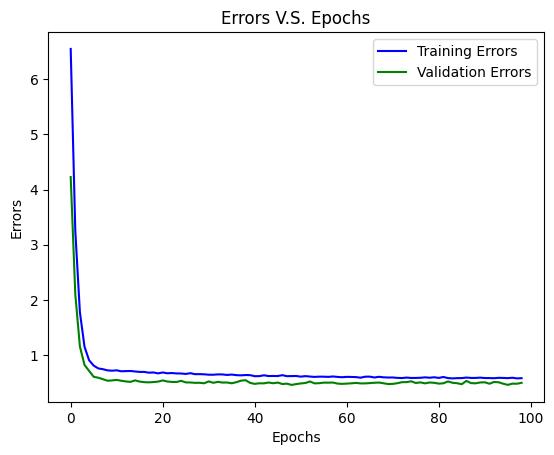

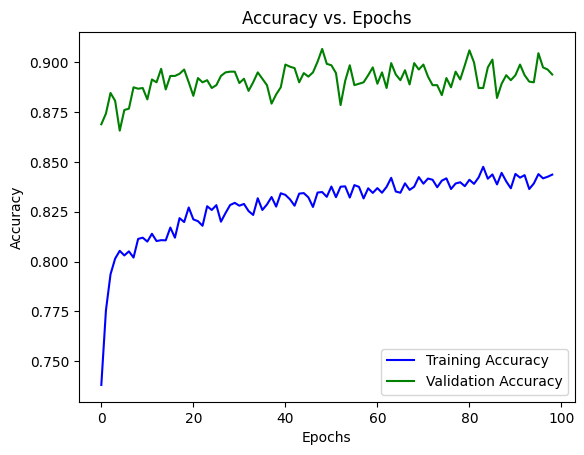

In [14]:
# train the model
# perform early stopping using the validation set
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 50, mode = "min", min_delta = 0.001, verbose = 1, restore_best_weights = True)
# save model (keep the network parameters) with lowest validation error
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_ResNet50.keras", save_best_only = True, monitor = "val_loss", mode = "min", verbose = 1)
ResNet50_history = ResNet50_model.fit(train_data,
                                      validation_data = validation_data,
                                      epochs = 100,
                                      callbacks = [early_stopping, checkpoint])

# plot training and validation errors
plt.plot(ResNet50_history.history["loss"], "blue", label = "Training Errors")
plt.plot(ResNet50_history.history["val_loss"], "green", label = "Validation Errors")
plt.xlabel("Epochs")
plt.ylabel("Errors")
plt.legend()
plt.title("Errors V.S. Epochs")
plt.show()

# plot training and validation accuracy
plt.plot(ResNet50_history.history["accuracy"], "blue", label = "Training Accuracy")
plt.plot(ResNet50_history.history["val_accuracy"], "green", label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")
plt.show()

#### ● ResNet101

Epoch 1/100
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6877 - loss: 7.7858 - precision: 0.7413 - recall: 0.6249
Epoch 1: val_loss improved from inf to 4.20827, saving model to best_ResNet101.keras
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 78s 28ms/step - accuracy: 0.6877 - loss: 7.7853 - precision: 0.7414 - recall: 0.6249 - val_accuracy: 0.8639 - val_loss: 4.2083 - val_precision: 0.8738 - val_recall: 0.8514
Epoch 2/100
2244/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7846 - loss: 3.7679 - precision: 0.8175 - recall: 0.7455
Epoch 2: val_loss improved from 4.20827 to 2.11090, saving model to best_ResNet101.keras
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 66s 28ms/step - accuracy: 0.7846 - loss: 3.7672 - precision: 0.8175 - recall: 0.7455 - val_accuracy: 0.8738 - val_loss: 2.1109 - val_precision: 0.8839 - val_recall: 0.8653
Epoch 3/100
2245/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7996 - loss: 2.0103 - precision: 0.8325 - recall: 0.7601
Epoch 3: val_loss improved from 2.11090

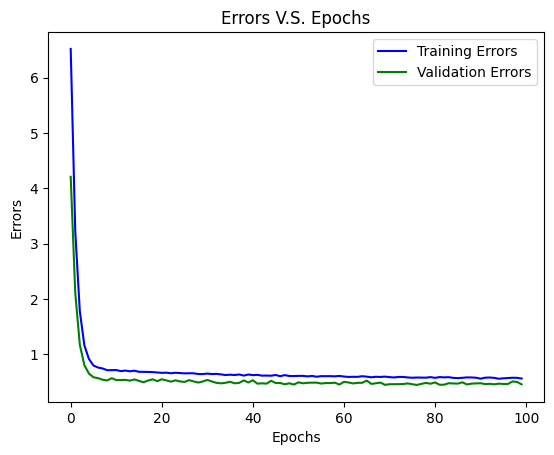

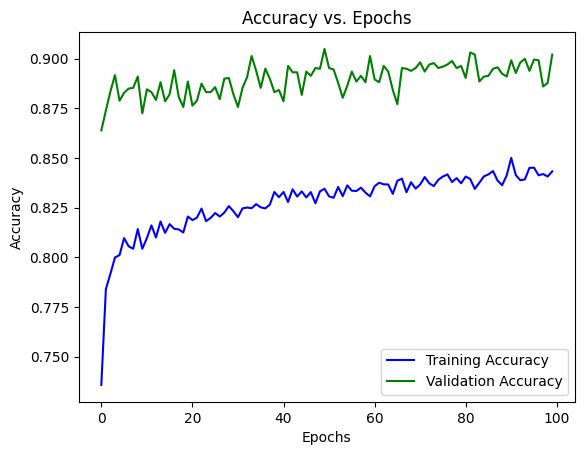

In [21]:
# train the model
# perform early stopping using the validation set
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 50, mode = "min", min_delta = 0.001, verbose = 1, restore_best_weights = True)
# save model (keep the network parameters) with lowest validation error
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_ResNet101.keras", save_best_only = True, monitor = "val_loss", mode = "min", verbose = 1)
ResNet101_history = ResNet101_model.fit(train_data,
                                        validation_data = validation_data,
                                        epochs = 100,
                                        callbacks = [early_stopping, checkpoint])

# plot training and validation errors
plt.plot(ResNet101_history.history["loss"], "blue", label = "Training Errors")
plt.plot(ResNet101_history.history["val_loss"], "green", label = "Validation Errors")
plt.xlabel("Epochs")
plt.ylabel("Errors")
plt.legend()
plt.title("Errors V.S. Epochs")
plt.show()

# plot training and validation accuracy
plt.plot(ResNet101_history.history["accuracy"], "blue", label = "Training Accuracy")
plt.plot(ResNet101_history.history["val_accuracy"], "green", label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")
plt.show()

#### ● EfficientNetB0

Epoch 1/100
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6268 - loss: 4.7872 - precision: 0.6927 - recall: 0.5525
Epoch 1: val_loss improved from inf to 2.88570, saving model to best_EfficientNet.keras
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.6268 - loss: 4.7870 - precision: 0.6927 - recall: 0.5525 - val_accuracy: 0.8742 - val_loss: 2.8857 - val_precision: 0.8848 - val_recall: 0.8649
Epoch 2/100
2243/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7809 - loss: 2.7976 - precision: 0.8184 - recall: 0.7392
Epoch 2: val_loss improved from 2.88570 to 1.75257, saving model to best_EfficientNet.keras
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.7810 - loss: 2.7971 - precision: 0.8184 - recall: 0.7392 - val_accuracy: 0.8785 - val_loss: 1.7526 - val_precision: 0.8886 - val_recall: 0.8728
Epoch 3/100
2245/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7917 - loss: 1.8053 - precision: 0.8304 - recall: 0.7479
Epoch 3: val_loss improved from 1

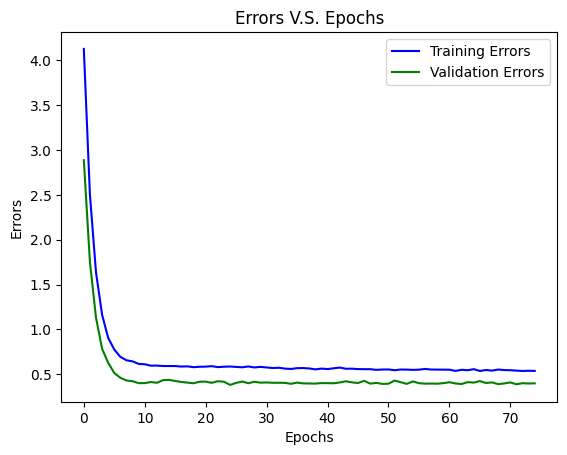

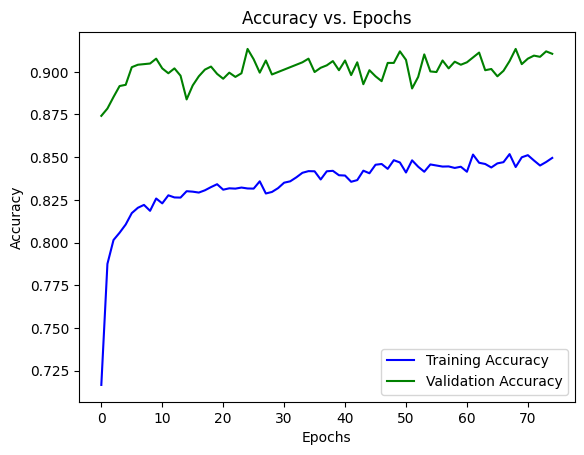

In [24]:
# train the model
# perform early stopping using the validation set
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 50, mode = "min", min_delta = 0.001, verbose = 1, restore_best_weights = True)
# save model (keep the network parameters) with lowest validation error
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_EfficientNet.keras", save_best_only = True, monitor = "val_loss", mode = "min", verbose = 1)
EfficientNet_history = EfficientNet_model.fit(train_data,
                                              validation_data = validation_data,
                                              epochs = 100,
                                              callbacks = [early_stopping, checkpoint])

# plot training and validation errors
plt.plot(EfficientNet_history.history["loss"], "blue", label = "Training Errors")
plt.plot(EfficientNet_history.history["val_loss"], "green", label = "Validation Errors")
plt.xlabel("Epochs")
plt.ylabel("Errors")
plt.legend()
plt.title("Errors V.S. Epochs")
plt.show()

# plot training and validation accuracy
plt.plot(EfficientNet_history.history["accuracy"], "blue", label = "Training Accuracy")
plt.plot(EfficientNet_history.history["val_accuracy"], "green", label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")
plt.show()

#### ● VGG16

Epoch 1/100
2242/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5120 - loss: 4.3345 - precision: 0.6128 - recall: 0.3796
Epoch 1: val_loss improved from inf to 2.69903, saving model to best_VGG16.keras
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.5123 - loss: 4.3332 - precision: 0.6131 - recall: 0.3799 - val_accuracy: 0.8072 - val_loss: 2.6990 - val_precision: 0.8341 - val_recall: 0.7687
Epoch 2/100
2242/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7051 - loss: 2.7017 - precision: 0.7730 - recall: 0.6313
Epoch 2: val_loss improved from 2.69903 to 1.77794, saving model to best_VGG16.keras
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.7052 - loss: 2.7011 - precision: 0.7730 - recall: 0.6313 - val_accuracy: 0.8297 - val_loss: 1.7779 - val_precision: 0.8524 - val_recall: 0.8029
Epoch 3/100
2243/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7308 - loss: 1.8816 - precision: 0.7919 - recall: 0.6489
Epoch 3: val_loss improved from 1.77794 to 1.24488

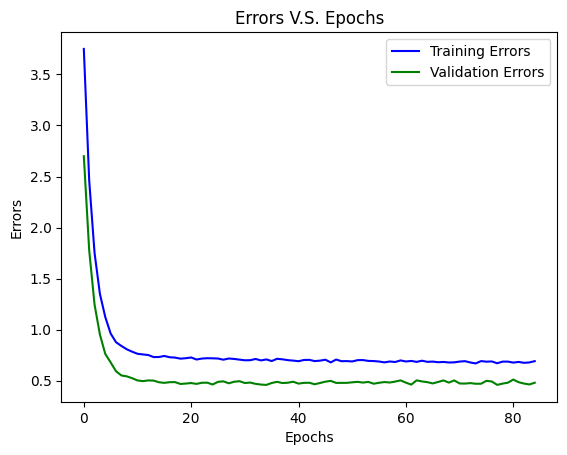

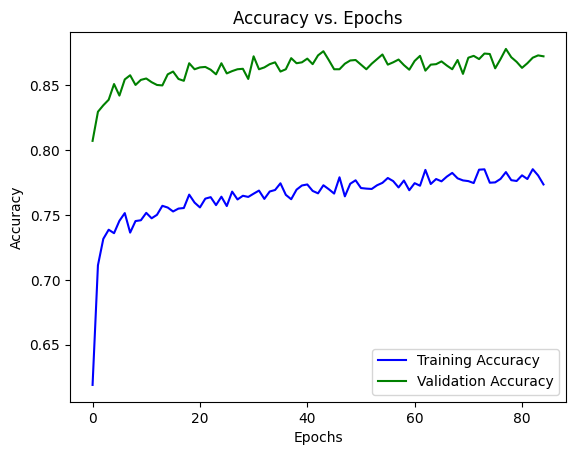

In [27]:
# train the model
# perform early stopping using the validation set
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 50, mode = "min", min_delta = 0.001, verbose = 1, restore_best_weights = True)
# save model (keep the network parameters) with lowest validation error
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_VGG16.keras", save_best_only = True, monitor = "val_loss", mode = "min", verbose = 1)
VGG16_history = VGG16_model.fit(train_data,
                                validation_data = validation_data,
                                epochs = 100,
                                callbacks = [early_stopping, checkpoint])

# plot training and validation errors
plt.plot(VGG16_history.history["loss"], "blue", label = "Training Errors")
plt.plot(VGG16_history.history["val_loss"], "green", label = "Validation Errors")
plt.xlabel("Epochs")
plt.ylabel("Errors")
plt.legend()
plt.title("Errors V.S. Epochs")
plt.show()

# plot training and validation accuracy
plt.plot(VGG16_history.history["accuracy"], "blue", label = "Training Accuracy")
plt.plot(VGG16_history.history["val_accuracy"], "green", label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")
plt.show()

#### v. Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [18]:
def evaluate_model(model, data):
    # get true class and predicted class
    true_class = []
    predicted_class = []
    predicted_probs = []
    for images, classes in data:
        prediction = model.predict(images, verbose = 0)
        true_class.extend(np.argmax(classes.numpy(), axis = 1))
        predicted_class.extend(np.argmax(prediction, axis = 1))
        predicted_probs.extend(prediction)

    # classification report
    report = classification_report(true_class, predicted_class, target_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"])

    # Loss, Accuracy, Precision, Recall
    loss, accuracy, precision, recall = model.evaluate(data, verbose = 0)
    # F1-score
    f1 = 2 * (precision * recall) / (precision + recall)
    # AUC
    try:
        auc = roc_auc_score(true_class, predicted_probs, multi_class = "ovr", average = "weighted")
    except ValueError:
        auc = float("nan")

    # results
    print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}, F1_score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)

#### ● ResNet50

In [20]:
print("ResNet50 Classification Report")

print("\nTrain Data:")
print(evaluate_model(ResNet50_model, train_data))

print("\nValidation Data:")
print(evaluate_model(ResNet50_model, validation_data))

print("\nTest Data:")
print(evaluate_model(ResNet50_model, test_data))

ResNet50 Classification Report

Train Data:
Accuracy: 0.9030, Loss: 0.4403, Precision: 0.9088, Recall: 0.8955, AUC: 0.9900, F1_score: 0.9021

Classification Report:
              precision    recall  f1-score   support

   buildings       0.94      0.91      0.93      1761
      forest       0.99      0.98      0.98      1835
     glacier       0.85      0.83      0.84      1929
    mountain       0.87      0.81      0.84      1998
         sea       0.87      0.94      0.90      1797
      street       0.91      0.96      0.93      1907

    accuracy                           0.90     11227
   macro avg       0.90      0.90      0.90     11227
weighted avg       0.90      0.90      0.90     11227

None

Validation Data:
Accuracy: 0.9066, Loss: 0.4567, Precision: 0.9111, Recall: 0.8981, AUC: 0.9883, F1_score: 0.9045

Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.92       430
      forest       0.98      0.99      

#### ● ResNet101

In [22]:
print("ResNet101 Classification Report")

print("\nTrain Data:")
print(evaluate_model(ResNet101_model, train_data))

print("\nValidation Data:")
print(evaluate_model(ResNet101_model, validation_data))

print("\nTest Data:")
print(evaluate_model(ResNet101_model, test_data))

ResNet101 Classification Report

Train Data:
Accuracy: 0.9099, Loss: 0.4062, Precision: 0.9164, Recall: 0.9040, AUC: 0.9909, F1_score: 0.9101

Classification Report:
              precision    recall  f1-score   support

   buildings       0.94      0.92      0.93      1761
      forest       0.99      0.98      0.98      1835
     glacier       0.84      0.85      0.85      1929
    mountain       0.87      0.83      0.85      1998
         sea       0.91      0.94      0.92      1797
      street       0.91      0.95      0.93      1907

    accuracy                           0.91     11227
   macro avg       0.91      0.91      0.91     11227
weighted avg       0.91      0.91      0.91     11227

None

Validation Data:
Accuracy: 0.8970, Loss: 0.4498, Precision: 0.9062, Recall: 0.8917, AUC: 0.9882, F1_score: 0.8989

Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.91      0.92       430
      forest       0.98      0.98     

#### ● EfficientNetB0

In [25]:
print("EfficientNetB0 Classification Report")

print("\nTrain Data:")
print(evaluate_model(EfficientNet_model, train_data))

print("\nValidation Data:")
print(evaluate_model(EfficientNet_model, validation_data))

print("\nTest Data:")
print(evaluate_model(EfficientNet_model, test_data))

EfficientNetB0 Classification Report

Train Data:
Accuracy: 0.9130, Loss: 0.3698, Precision: 0.9169, Recall: 0.9069, AUC: 0.9918, F1_score: 0.9119

Classification Report:
              precision    recall  f1-score   support

   buildings       0.91      0.93      0.92      1761
      forest       0.98      0.99      0.99      1835
     glacier       0.85      0.82      0.84      1929
    mountain       0.86      0.85      0.86      1998
         sea       0.95      0.96      0.96      1797
      street       0.93      0.92      0.92      1907

    accuracy                           0.91     11227
   macro avg       0.91      0.91      0.91     11227
weighted avg       0.91      0.91      0.91     11227

None

Validation Data:
Accuracy: 0.9134, Loss: 0.3805, Precision: 0.9194, Recall: 0.9102, AUC: 0.9913, F1_score: 0.9148

Classification Report:
              precision    recall  f1-score   support

   buildings       0.91      0.94      0.93       430
      forest       0.97      1.00

#### ● VGG16

In [28]:
print("VGG16 Classification Report")

print("\nTrain Data:")
print(evaluate_model(VGG16_model, train_data))

print("\nValidation Data:")
print(evaluate_model(VGG16_model, validation_data))

print("\nTest Data:")
print(evaluate_model(VGG16_model, test_data))

VGG16 Classification Report

Train Data:
Accuracy: 0.8702, Loss: 0.4496, Precision: 0.8833, Recall: 0.8570, AUC: 0.9832, F1_score: 0.8700

Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.89      0.90      1761
      forest       0.98      0.99      0.98      1835
     glacier       0.82      0.74      0.77      1929
    mountain       0.77      0.82      0.79      1998
         sea       0.87      0.89      0.88      1797
      street       0.90      0.91      0.91      1907

    accuracy                           0.87     11227
   macro avg       0.87      0.87      0.87     11227
weighted avg       0.87      0.87      0.87     11227

None

Validation Data:
Accuracy: 0.8678, Loss: 0.4586, Precision: 0.8826, Recall: 0.8546, AUC: 0.9824, F1_score: 0.8684

Classification Report:
              precision    recall  f1-score   support

   buildings       0.89      0.91      0.90       430
      forest       0.97      0.99      0.9

#### There is no model clearly outperforms the others, but EfficientNetB0 shows a slightly better performance, and VGG16 has slightly lower accuracy, precision, recall, AUC and F1 score.

## Reference:
##### [1] GeeksforGeeks. Image Resizing using OpenCV | Python. https://www.geeksforgeeks.org/image-resizing-using-opencv-python/
##### [2] GeeksforGeeks. Python OpenCV | cv2.imwrite() method. https://www.geeksforgeeks.org/python-opencv-cv2-imwrite-method/
##### [4] GeeksforGeeks. Image Transformations using OpenCV in Python. https://www.geeksforgeeks.org/image-transformations-using-opencv-in-python/
##### [5] TutorialsPoint. How to change the contrast and brightness of an image using OpenCV in Python? https://www.tutorialspoint.com/how-to-change-the-contrast-and-brightness-of-an-image-using-opencv-in-python
##### [6] GeeksforGeeks. Python OpenCV – cv2.flip() method. https://www.geeksforgeeks.org/python-opencv-cv2-flip-method/
##### [7] Stack Overflow.Trying to understand how img = np.zeros((300,512,3), np.uint8) gives us a black window [closed]. https://stackoverflow.com/questions/63857009/trying-to-understand-how-img-np-zeros300-512-3-np-uint8-gives-us-a-black
##### [8] Stack Overflow. Add padding to images to get them into the same shape. https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape
##### [9] TensorFlow. tf.keras.preprocessing.image_dataset_from_directory. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
##### [10] TensorFlow. Use a GPU. https://www.tensorflow.org/guide/gpu
##### [11] Piazza. question@1159. https://piazza.com/class/m09cnglrrao1gr/post/1159
##### [12] Stack Overflow. Dataset shuffled with Keras. https://stackoverflow.com/questions/73869781/dataset-shuffled-with-keras
##### [13] TensorFlow. tf.keras.applications.VGG16. https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16
##### [14] TensorFlow. tf.keras.applications.ResNet101. https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet101
##### [15] TensorFlow. tf.keras.applications.EfficientNetB0. https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0
##### [16] TensorFlow. tf.keras.applications.ResNet50. https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50
##### [17] Keras. Image classification via fine-tuning with EfficientNet. https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
##### [18] Kaggle. EfficientNetB0 Training. https://www.kaggle.com/code/quynhngo7075/efficientnetb0-training
##### [19] Machine Learning Mastery. Use Early Stopping to Halt the Training of Neural Networks At the Right Time. https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
##### [20] scikit-learn. classification_report. https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html